In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from optimization import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fundamental constants and simulation parameters
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.75e-1                   # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 5              # amplitude of modal source (A/L0^2?)

In [37]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [38]:
# geometric parameters
L = 3         # length of box (L0)
H = 3         # height of box (L0)
w = .2        # width of waveguides (L0)
d = H/2       # distance between waveguides (L0)
l = 2         # length of waveguide from PML to box (L0)
spc = 0.5     # space between box and PML (L0)

Computed a domain with 123 grids in x and 123 grids in y
The simulation has 26 grids per free space wavelength


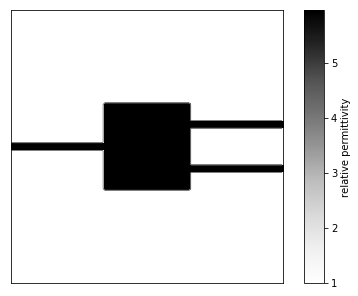

In [39]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, l, spc, NPML, eps_start=eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Fdfd(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [40]:
# check to make sure the number of points in each waveguide is the same
eps = simulation.eps_r
pts_in = np.sum(eps[NPML[0]+3,:] > 1)
pts_top = np.sum(eps[-NPML[0]-3,:ny] > 1)
pts_bot = np.sum(eps[-NPML[0]-3,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))
assert pts_in == pts_top == pts_bot, "number of grid points in each waveguide is not consistent"

waveguide has 3 points in in port
waveguide has 3 points in top port
waveguide has 3 points in bottom port


In [41]:
# set the modal source and probes
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(d/dl), scale=source_amp)
simulation.setup_modes()
print('Calculate an input power of {} Watts/L0'.format(simulation.W_in))

# top modal profile
top = Fdfd(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)

# bottom modal profile
bot = Fdfd(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

Calculate an input power of 0.27725753774525835 Watts/L0


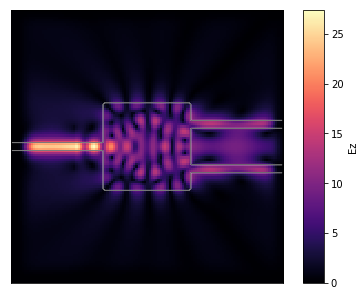

In [42]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

## Purely Linear

## Both Linear and Nonlinear

In [43]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*J_top)))# - np.sum(np.square(np.abs(e*J_bot)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*J_bot)))# - np.sum(np.square(np.abs(e*J_top)))
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*J_top# - np.conj(e)*J_bot
dJdE['nonlinear'] = lambda e: np.conj(e)*J_bot# - np.conj(e)*J_top
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [45]:
# run the optimization

# optimization parameters
Nsteps = 200
step_size = .1
solver = 'newton'
opt_method = 'adam'

# initialize an optimization object with the above parameters and objective function information
simulation.reset_eps(eps_r)
optimization = Optimization(Nsteps=Nsteps, J=J, dJdE=dJdE, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method, max_ind_shift=max_ind_shift)

# run the optimization with the simulation and the region and nonlinearity information
new_eps = optimization.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

100% (200 of 200) |######################| Elapsed Time: 0:03:08 ETA:  00:00:00

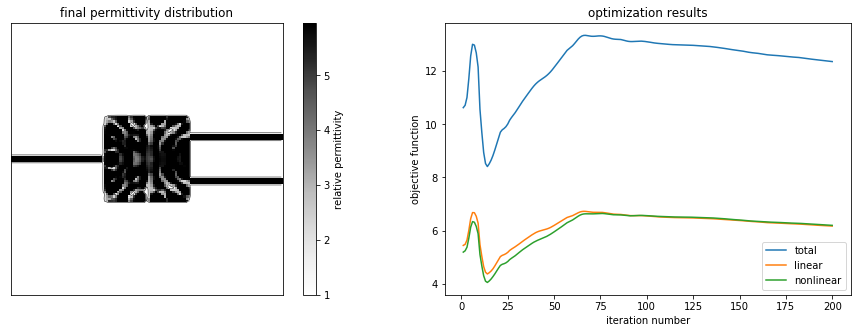

In [46]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)

plt.show()

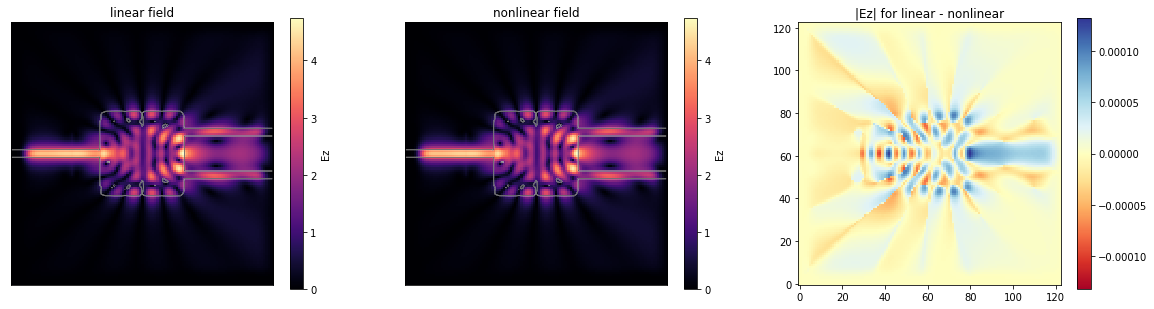

In [47]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs(ax=ax2)
ax2.set_title('nonlinear field')

# difference
difference = np.abs(Ez).T - np.abs(Ez_nl).T
im = plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu', origin='lower')
f.colorbar(im, ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.005264670914227301


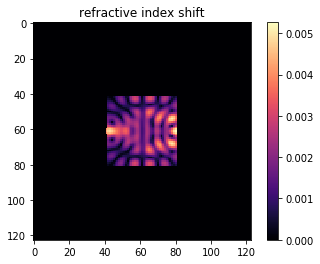

In [48]:
# compute the refractive index shift
index_shift = optimization.compute_index_shift(simulation, regions, nonlin_fns)
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

In [34]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(d/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(d/2/dl))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(l/2/dl), ny], int(d/dl))

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
W_top_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(d/2/dl))
W_bot_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(d/2/dl))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(l/2/dl), ny], int(d/dl))

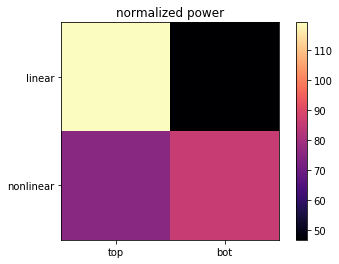

S-matrix = 
[[119.12592311  46.79825858]
 [ 75.29522179  85.99686181]]


In [35]:
# compute and plot S-matrix
S = np.array([[W_top_lin, W_bot_lin]/W_in,[W_top_nl, W_bot_nl]/W_in])
plt.imshow(S, cmap='magma')
plt.colorbar()
plt.xticks([0,1], ['top','bot'])
plt.yticks([0,1], ['linear','nonlinear'])
plt.title('normalized power')
plt.show()
print("S-matrix = \n{}".format(S))

In [36]:
# save this nice permittivity to a file
# np.save('../data/eps_good', new_eps)

# eps_saved = np.load('../data/eps_good.npy')

# eps_saved[design_region == 0] = eps_r[design_region==0]
# simulation.reset_eps(eps_saved)